In [1]:
import sys
sys.path.append('/home/g/Desktop/git/nodules/src/')

import candidates as cd
import candgen as luna

import os
import math
import copy
import time
import scipy
import skimage.feature
import scipy.ndimage
import scipy.misc as scipy_misc
import scipy.ndimage.morphology as morphology
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk

from glob import glob
from skimage import measure
from skimage import feature

SAMPLES_PATH = '/scr/nodules/luna/val/subset0/'
SAMPLE_CANDIDATES_PATH = '/home/g/Desktop/git/nodules/resources/annotations.csv'

In [134]:
import plotly.plotly as plotly

In [2]:
time1 = time.time()
for parent, subdir, files in os.walk(SAMPLES_PATH):
  filelist = glob(parent+'/*.mhd')
  filepathlist = copy.deepcopy(filelist)
templist = []
for f in filelist:
  f = f.split('/')
  f = f[-1]
  templist.append(f[:-4])
filelist = templist
del(templist)

In [439]:
for no in range(len(filelist)):
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.187451715205085403623595258748':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.295420274214095686326263147663':
    print no

9
23
38
87


In [444]:
for no in range(len(filelist)):
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.154677396354641150280013275227':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.138080888843357047811238713686':
    print no
  if filelist[no] == '1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565':
    print no

25
32
45
52
57


In [410]:
no = 87
candlist = pd.read_csv(SAMPLE_CANDIDATES_PATH)
currentNodules = candlist[candlist['seriesuid'] == filelist[no]]
print currentNodules[['coordX','coordY','coordZ','diameter_mm']]

        coordX     coordY      coordZ  diameter_mm
794 -46.901443  75.757022 -160.622698     7.000524
795 -70.851189  43.232739 -161.903079     5.103332
796 -65.853558  81.310802 -179.945889     4.091254
797 -78.608736  83.603167 -180.331341     3.604122
798 -68.579078  88.634206 -190.872618     4.364981


In [411]:
itk = sitk.ReadImage(filepathlist[no])
image, _ = luna.loadItk(filepathlist[no],None)
origin = np.array(itk.GetOrigin())
spacing = np.array(itk.GetSpacing())
cx = currentNodules['coordX']
cx = cx.as_matrix()
cy = currentNodules['coordY']
cy = cy.as_matrix()
cz = currentNodules['coordZ']
cz = cz.as_matrix()
di = currentNodules['diameter_mm']
di = di.as_matrix()

In [412]:
ino = 0
tcx = cx[ino]
tcy = cy[ino]
tcz = cz[ino]
d = di[ino]
volume = 3.14159265359*(d*d*d/8)*4/3.
center = np.asarray([tcx,tcy,tcz])
newCenter = (center-origin)/spacing
coords = center-origin
coords = np.round(coords).astype(int)

In [413]:
bimage = copy.deepcopy(image)

In [414]:
t1 = time.time()
oldImage = copy.deepcopy(image[coords[2]-20:coords[2]+20,coords[1]-20:coords[1]+20,coords[0]-20:coords[0]+20])
image = copy.deepcopy(bimage)
#image = np.clip(image,-1000,-300)
#image[image>=-350] = -2000
segmentation = cd.filterHessian(cd.multiscaleHessian(image[coords[2]-20:coords[2]+20,coords[1]-20:coords[1]+20,coords[0]-20:coords[0]+20]),THRESHOLD=1.25)
segmentedImage = copy.deepcopy(segmentation)
segmentedImage = cd.optVolumeThresholding(segmentedImage,mn=6,mx=20000)
t2 = time.time()
print t2-t1

COMPUTING HESSIANS FOR ALL GUASSIANS
GETTING GAUSSIAN SCALES
COMPUTING APPROX HESSIAN
COMPUTING APPROX HESSIAN
COMPUTING APPROX HESSIAN
COMPUTING APPROX HESSIAN
COMPUTING APPROX HESSIAN
COMPUTING APPROX HESSIAN
FILTERING HESSIAN VALUES
GETTING GAUSSIAN SCALES
HESSIAN NO: 0
  SLICE: 0/40
TIME: 1.49220895767
HESSIAN NO: 1
  SLICE: 0/40
TIME: 1.45354914665
HESSIAN NO: 2
  SLICE: 0/40
TIME: 1.52814102173
HESSIAN NO: 3
  SLICE: 0/40
TIME: 1.31472802162
HESSIAN NO: 4
  SLICE: 0/40
TIME: 1.31904578209
HESSIAN NO: 5
  SLICE: 0/40
TIME: 1.33852696419
OPTIMIZED VOLUME THRESHOLDING
8.51245903969


In [415]:
labels = measure.label(segmentedImage,connectivity=1)
print np.max(labels)
val = labels[20,20,20]
if val == 0:
  val = labels[19,20,20]
  if val == 0:
    val = labels[19,20,19]
    if val == 0:
      val = labels[20,19,20]
      if val == 0:
        val = labels[20,20,19]
        if val == 0:
          val = labels[20,19,19]
          if val == 0:
            val = labels[19,19,19]
            if val == 0:
              val = labels[19,19,20]
              if val == 0:
                pass #continue
labels[labels!=val] = 0
labels[labels==val] = 1
nodulesCOM = scipy.ndimage.measurements.center_of_mass(segmentedImage, labels)
tcoords = np.round(np.array(nodulesCOM)).astype(int)
print tcoords
oldImage[tcoords[2],tcoords[1],tcoords[0]] = 1000

106
[19 21 24]


In [416]:
print val

42


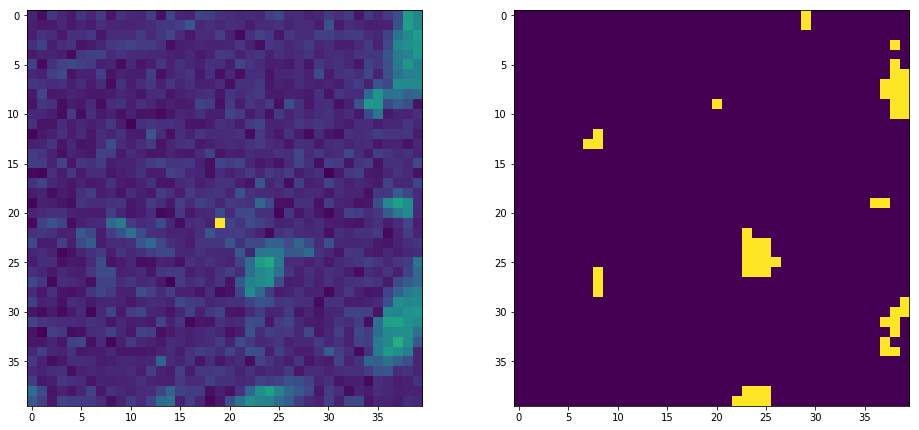

In [417]:
plt.figure(figsize=(16,16))
plt.subplot(222)
plt.imshow(segmentedImage[tcoords[2],:,:])
plt.subplot(221)
plt.imshow(oldImage[tcoords[2],:,:])
plt.show()

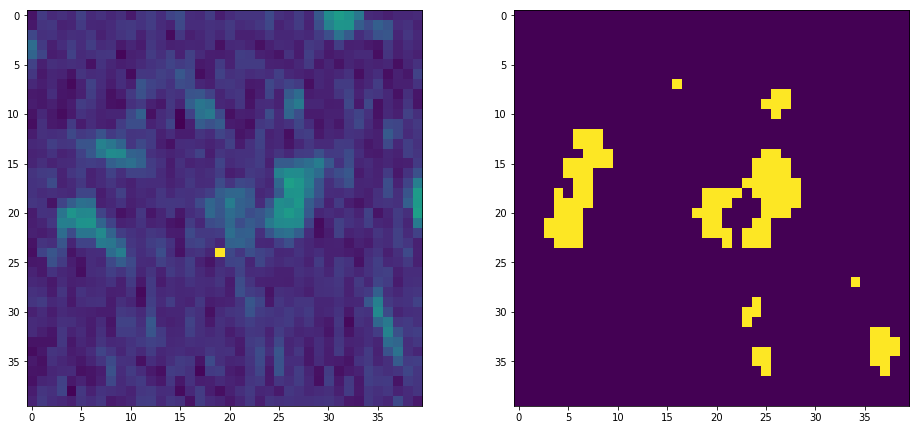

In [418]:
plt.figure(figsize=(16,16))
plt.subplot(222)
plt.imshow(segmentedImage[:,tcoords[1],:])
plt.subplot(221)
plt.imshow(oldImage[:,tcoords[1],:])
plt.show()

PRECISION VOLUME THRESHOLDING


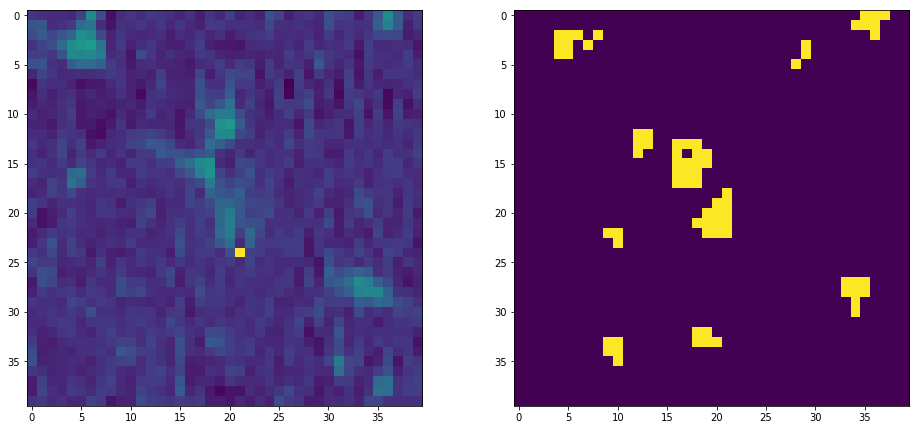

In [419]:
segmentedImage = cd.volumeThresholding(segmentedImage)
plt.figure(figsize=(16,16))
plt.subplot(222)
plt.imshow(segmentedImage[:,:,tcoords[0]])
plt.subplot(221)
plt.imshow(oldImage[:,:,tcoords[0]])
plt.show()

# NOTE: Can get actual segmented volumes from original annotations.

Segmentation volume: 316
Approximate actual volume: 179.63470758


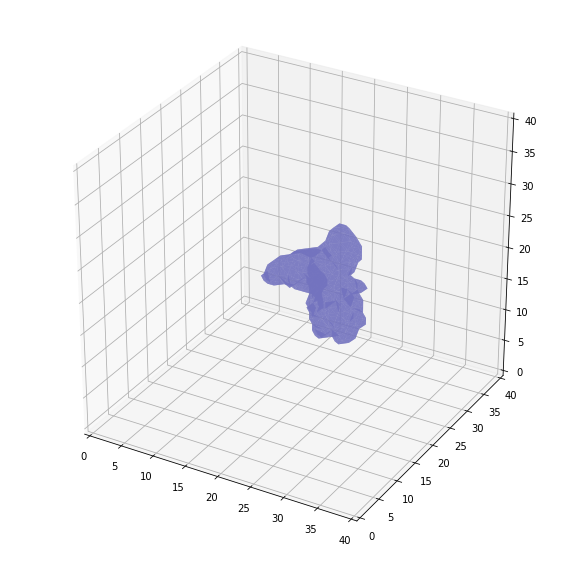

In [420]:
segmentationVolume = np.sum(labels)
print "Segmentation volume: " + str(segmentationVolume)
print "Approximate actual volume: " + str(volume)
cd.plot3d(labels,0)

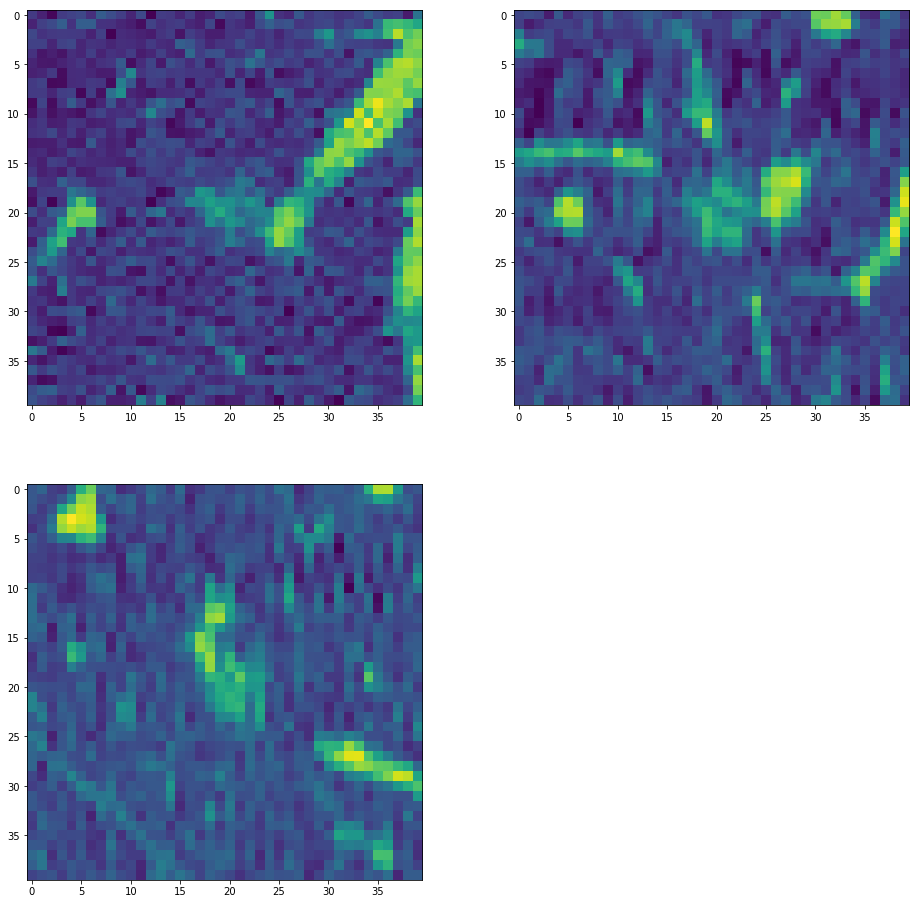

In [421]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(oldImage[20,:,:])
plt.subplot(222)
plt.imshow(oldImage[:,20,:])
plt.subplot(223)
plt.imshow(oldImage[:,:,20])
plt.show()

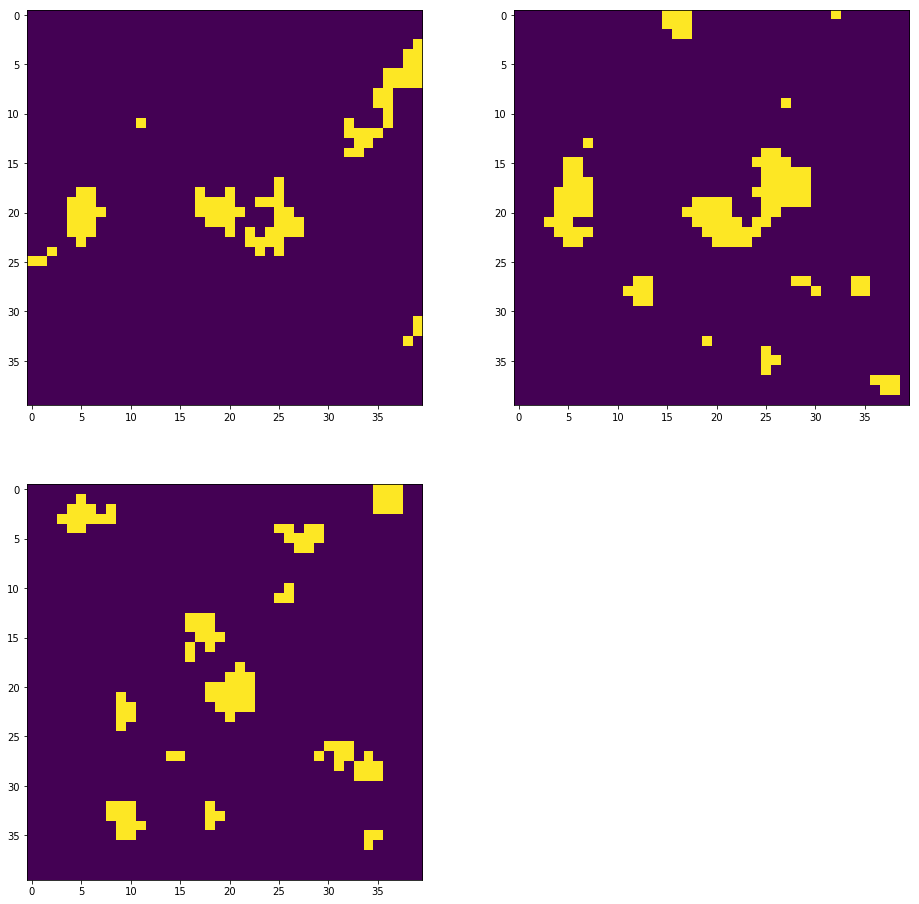

In [422]:
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(segmentedImage[20,:,:])
plt.subplot(222)
plt.imshow(segmentedImage[:,20,:])
plt.subplot(223)
plt.imshow(segmentedImage[:,:,20])
plt.show()

In [423]:
labels = measure.label(segmentedImage,connectivity=1)
print np.max(labels)

84


In [198]:
labels9 = copy.deepcopy(labels) #val = 52

In [180]:
labels23 = copy.deepcopy(labels) #val = 58?

In [204]:
labels38 = copy.deepcopy(labels) #val = 38

In [226]:
image9 = copy.deepcopy(oldImage)

In [220]:
image23 = copy.deepcopy(oldImage)

In [231]:
image38 = copy.deepcopy(oldImage)

In [219]:
props9 = measure.regionprops(labels9,image9)

In [232]:
props38 = measure.regionprops(labels38,image38)

In [426]:
image87 = copy.deepcopy(oldImage) #val = 42
labels87 = copy.deepcopy(labels)
props87 = measure.regionprops(labels87,image87)

In [54]:
props = measure.regionprops(labels, segmentedImage)

In [55]:
area = props[0].area

In [56]:
bbox = props[0].bbox

In [57]:
du = bbox[3]-bbox[0]
dv = bbox[4]-bbox[1]
dw = bbox[5]-bbox[2]
print du*dv*dw

1080


In [58]:
print props[0].centroid

(21.626415094339624, 22.279245283018867, 18.135849056603774)


In [233]:
def props(labels,oldImage):
  label = np.zeros(labels.shape)
  intensities = np.zeros((np.max(labels),7))
  for i in range(1,np.max(labels)):
    label *= 0
    label = np.where(labels==i,1,0)
    props = measure.regionprops(label, oldImage)
    mx_i = props[0].max_intensity
    mean_i = props[0].mean_intensity
    mn_i = props[0].min_intensity
    irange = abs(mn_i-mx_i)
    intensities[i-1,6] = irange
    intensities[i-1,0] = mx_i
    intensities[i-1,1] = mean_i
    di = abs(mx_i-mean_i)
    intensities[i-1,2] = di
    area = props[0].area
    intensities[i-1,3] = area
    bbox = props[0].bbox
    du = bbox[3]-bbox[0]
    dv = bbox[4]-bbox[1]
    dw = bbox[5]-bbox[2]
    bbox_area = du*dv*dw
    bbox_ratio = float(area)/float(bbox_area)
    intensities[i-1,4] = bbox_area
    intensities[i-1,5] = bbox_ratio
  return intensities

In [427]:
intensities = props(labels87,image87)

In [435]:
for i in range(len(intensities)):
  if intensities[i,3] == 316:
    print intensities[i]
    print i

[  2.15000000e+02  -3.65819620e+02   5.80819620e+02   3.16000000e+02
   1.98000000e+03   1.59595960e-01   1.20200000e+03]
33


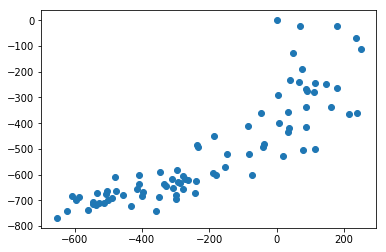

In [429]:
plt.figure()
plt.plot(intensities[:,0],intensities[:,1],"o")
plt.show()
plt.clf()

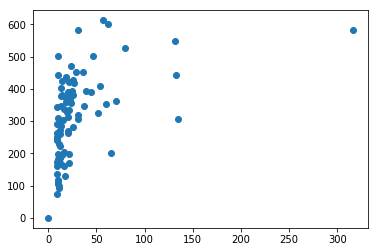

In [430]:
plt.figure()
plt.plot(intensities[:,3],intensities[:,2],"o")
plt.show()
plt.clf()

# WORKING FILTERS FOR HESSIAN LOW DENSITY FILTER

In [433]:
fintensities = copy.deepcopy(intensities)
fintensities[intensities[:,3] < 50] = 0
fintensities[intensities[:,1] > -500] = 0
#fintensities[intensities[:,6] > 600] = 0 

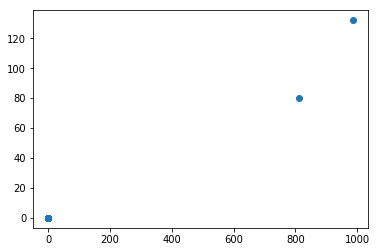

In [434]:
plt.figure()
plt.plot(fintensities[:,6],fintensities[:,3],"o")
plt.show()
plt.clf()